# MARATONA BEHIND THE CODE 2020

## DESAFIO 7: TNT

## Testes com modelo XGBoost Otimizado

# Parte 01. Importando as bibliotecas

In [1]:
# Pacotes padrao
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

# Pacote do sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score
from sklearn.metrics import roc_auc_score, recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Pacote ML
from xgboost import XGBClassifier
import xgboost as xgb

# Pacote para balanceamento dos dados
from imblearn.over_sampling import SMOTE

# Pacote para hyperparametros
import optuna
import functools

# Desativando warnings no jupyter
import warnings
warnings.filterwarnings('ignore')

# Parte 02. Carregando o dataset de treino

In [2]:
# Criando um dataframe a partir da lista de dados vindo do IoT e gravados no NoSQL
treino = pd.read_csv(r'train_17015.csv')
print('Quantidade de registros e colunas: ',treino.shape)
treino.head()

Quantidade de registros e colunas:  (17015, 15)


,Tempo,Estacao,LAT,LONG,Movimentacao,Original_473,Original_269,Zero,Maca_Verde,Tangerina,Citrus,Acai_Guarana,Pessego,TARGET,row
0,2019-12-30,Fradique Coutinho,-23.5661,-46.6841,35386,24,45,61,42,19,22,15,9,NORMAL,10800
1,2018-01-08,Luz,-23.5365,-46.6332,124806,15,10,10,29,10,25,14,13,NORMAL,10808
2,2018-04-17,Luz,-23.5365,-46.6332,125215,53,1,55,18,18,6,37,8,REABASTECER,10907
3,2018-07-18,Luz,-23.5365,-46.6332,126476,36,5,57,38,15,43,43,18,REABASTECER,10998
4,2018-08-28,Luz,-23.5365,-46.6332,125917,79,10,8,37,32,30,18,15,NORMAL,11038


In [3]:
# Visualizando o tipo dos dados
treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17015 entries, 0 to 17014
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Tempo         16921 non-null  object 
 1   Estacao       17015 non-null  object 
 2   LAT           17015 non-null  float64
 3   LONG          17015 non-null  float64
 4   Movimentacao  17015 non-null  int64  
 5   Original_473  17015 non-null  int64  
 6   Original_269  17015 non-null  int64  
 7   Zero          17015 non-null  int64  
 8   Maca_Verde    17015 non-null  int64  
 9   Tangerina     17015 non-null  int64  
 10  Citrus        17015 non-null  int64  
 11  Acai_Guarana  17015 non-null  int64  
 12  Pessego       17015 non-null  int64  
 13  TARGET        17015 non-null  object 
 14  row           17015 non-null  int64  
dtypes: float64(2), int64(10), object(3)
memory usage: 1.9+ MB


,TARGET,%
NORMAL,11517,67.687
REABASTECER,5498,32.313


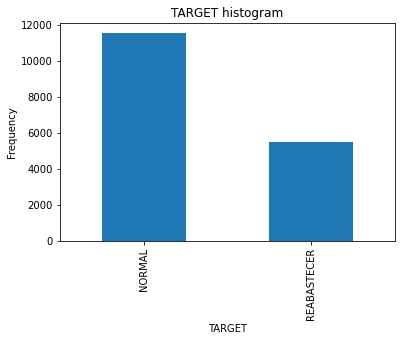

In [4]:
# Visualizando a distribuição das classes (variavel TARGET)
pd.value_counts(treino['TARGET']).plot.bar()
plt.title('TARGET histogram')
plt.xlabel('TARGET')
plt.ylabel('Frequency')

# Visualizando um df com quantidade e percentual da variavel TARGET
tmp = pd.DataFrame(treino['TARGET'].value_counts())
tmp['%'] = round(100*tmp['TARGET']/tmp['TARGET'].sum(),3)
tmp

# Parte 03. Feature Engineering

In [5]:
# Removendo colunas que não serão utilizadas no treinamento
treino = treino.drop(['Tempo','Estacao','Movimentacao','LAT','LONG', 'row'], axis = 1)

# Converte colunas para numerico
treino = treino.apply(pd.to_numeric, errors='ignore')

# Visualizando os primeiros registros
treino.head()

,Original_473,Original_269,Zero,Maca_Verde,Tangerina,Citrus,Acai_Guarana,Pessego,TARGET
0,24,45,61,42,19,22,15,9,NORMAL
1,15,10,10,29,10,25,14,13,NORMAL
2,53,1,55,18,18,6,37,8,REABASTECER
3,36,5,57,38,15,43,43,18,REABASTECER
4,79,10,8,37,32,30,18,15,NORMAL


# Parte 04. Modelagem Preditiva
> - Nesta fase estarei construindo os modelos preditivos
> - Vou utilizar o modelo XGB para treinamento

In [6]:
# Definindo alguns parametros
SEED  = 42

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

#### ***** Função para criar os dados de treino e teste/validação utilizando amostragem estratificada:
####
def train_test_split_strat(data, target, n_splits=1, test_size=0.2, random_state=42):
    # Criando a instância:
    split = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)

    # Criando os datasets de treino e teste utilizando amostragem estratificada:
    for train_index, test_index in split.split(data, data[target]):
        strat_train_set = data.loc[train_index]
        strat_test_set = data.loc[test_index]

    # Reset no índice do dataset de treino:
    strat_train_set.reset_index(drop=True, inplace=True)

    # Reset no índice do dataset de teste:
    strat_test_set.reset_index(drop=True, inplace=True)

    # Definição das colunas que serão features (variáveis preditoras):
    features = list(data.columns) # cria uma lista com todas as variáveis do dataset.
    features.remove(target) # remove a variável target.

    # Criação dos dados de treino:
    X_train = strat_train_set[features]
    y_train = strat_train_set[target]

    # Criação dos dados de teste:
    X_test = strat_test_set[features]
    y_test = strat_test_set[target]
    
    # Mostrando o resultado (número de observações em cada dataset):
    print(len(strat_train_set), "train +", len(strat_test_set), "test/valid", "=", (len(strat_train_set)+len(strat_test_set)),
          "total")
    
    y_train = y_train.astype("category").cat.codes
    y_test = y_test.astype("category").cat.codes
    
    
    X_train = StandardScaler().fit_transform(X_train)
    X_test = StandardScaler().fit_transform(X_test)
    
    # Retorna os dados de treino e teste:
    return (X_train, y_train, X_test, y_test)
    

In [8]:
# Split dos dados
X_treino, y_treino, X_teste, y_teste = train_test_split_strat(treino, 'TARGET', test_size = .2, random_state = SEED)    

13612 train + 3403 test/valid = 17015 total


### Sem Balanceamento dos dados

Acurácia: 75.49%
Sensibilidade : 0.6972727272727273
Especificidade : 0.7824576639166305


              precision    recall  f1-score   support

           0       0.84      0.78      0.81      2303
           1       0.60      0.70      0.65      1100

    accuracy                           0.75      3403
   macro avg       0.72      0.74      0.73      3403
weighted avg       0.77      0.75      0.76      3403



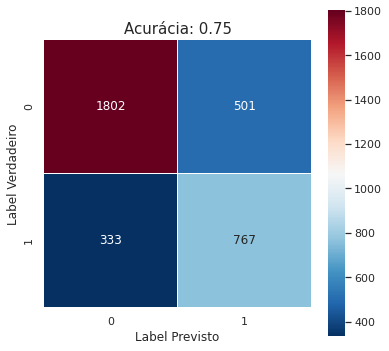

In [9]:
# Criando o modelo
modelo_xgb_v1 = XGBClassifier()

# Treinando o modelo
modelo_xgb_v1.fit(X_treino, y_treino)

# Fazendo previsões
xgb_y_pred = modelo_xgb_v1.predict(X_teste)
previsoes = [round(value) for value in xgb_y_pred]

# Avaliando as previsões
xgb_score_v1 = accuracy_score(y_teste, previsoes)
print("Acurácia: %.2f%%" % (xgb_score_v1 * 100.0))

# Cria a matriz de confusão
conf_matriz_xgb = confusion_matrix(y_teste, xgb_y_pred)
    
# Calcula especificidade e sensibilidade
speci_xgb = conf_matriz_xgb[0,0] / (conf_matriz_xgb[0,0] + conf_matriz_xgb[0,1])
sensi_xgb = conf_matriz_xgb[1,1] / (conf_matriz_xgb[1,0] + conf_matriz_xgb[1,1])

# Print
print('Sensibilidade :', sensi_xgb)
print('Especificidade :', speci_xgb)
print('\n')

# Matriz de Confusão gráfica
sns.set(rc={'figure.figsize':(6, 6)})
sns.heatmap(conf_matriz_xgb, 
            annot = True, 
            fmt = ".0f", 
            linewidths = .5, 
            square = True, 
            cmap = 'RdBu_r')

# Labels e Títulos
plt.ylabel('Label Verdadeiro')
plt.xlabel('Label Previsto')
plt.title('Acurácia: {:.2f}'.format(xgb_score_v1), size = 15)

# Relatório de Classificação
print(classification_report(y_teste, xgb_y_pred))

### Com Balanceamento dos dados

In [10]:
# Aplicando a funcao SMOTE
sm = SMOTE(random_state=SEED)
X_treino_bal, y_treino_bal = sm.fit_sample(X_treino, y_treino)

Acurácia: 61.12%
Sensibilidade : 0.9981818181818182
Especificidade : 0.42640034737299176


              precision    recall  f1-score   support

           0       1.00      0.43      0.60      2303
           1       0.45      1.00      0.62      1100

    accuracy                           0.61      3403
   macro avg       0.73      0.71      0.61      3403
weighted avg       0.82      0.61      0.61      3403



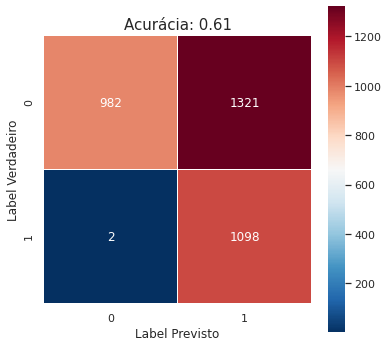

In [11]:
# Criando o modelo
modelo_xgb_v2 = XGBClassifier()

# Treinando o modelo
modelo_xgb_v2.fit(X_treino_bal, y_treino_bal)

# Fazendo previsões
xgb_y_pred = modelo_xgb_v2.predict(X_teste)
previsoes = [round(value) for value in xgb_y_pred]

# Avaliando as previsões
xgb_score_v2 = accuracy_score(y_teste, previsoes)
print("Acurácia: %.2f%%" % (xgb_score_v2 * 100.0))

# Cria a matriz de confusão
conf_matriz_xgb = confusion_matrix(y_teste, xgb_y_pred)
    
# Calcula especificidade e sensibilidade
speci_xgb = conf_matriz_xgb[0,0] / (conf_matriz_xgb[0,0] + conf_matriz_xgb[0,1])
sensi_xgb = conf_matriz_xgb[1,1] / (conf_matriz_xgb[1,0] + conf_matriz_xgb[1,1])

# Print
print('Sensibilidade :', sensi_xgb)
print('Especificidade :', speci_xgb)
print('\n')

# Matriz de Confusão gráfica
sns.set(rc={'figure.figsize':(6, 6)})
sns.heatmap(conf_matriz_xgb, 
            annot = True, 
            fmt = ".0f", 
            linewidths = .5, 
            square = True, 
            cmap = 'RdBu_r')

# Labels e Títulos
plt.ylabel('Label Verdadeiro')
plt.xlabel('Label Previsto')
plt.title('Acurácia: {:.2f}'.format(xgb_score_v2), size = 15)

# Relatório de Classificação
print(classification_report(y_teste, xgb_y_pred))

### Identificando os melhores Hyperparametros

In [12]:
def objective(trial):

    dtrain = xgb.DMatrix(X_treino, label=y_treino)
    dvalid = xgb.DMatrix(X_teste, label=y_teste)

    param = {
        "silent": 1,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    # Add a callback for pruning.
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    bst = xgb.train(param, dtrain, evals=[(dvalid, "validation")], callbacks=[pruning_callback])
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_teste, pred_labels)
    return accuracy

In [13]:
study_v2 = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=15), direction="maximize")
study_v2.optimize(objective, n_trials=100)
print(study_v2.best_trial)

[I 2020-09-11 19:10:30,558] A new study created in memory with name: no-name-7cc2b64c-bd2f-45b8-8ec4-153a57530ede


[19:10:30] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2020-09-11 19:10:30,591] Trial 0 finished with value: 0.6767558037026153 and parameters: {'booster': 'gblinear', 'lambda': 2.908049070853509e-08, 'alpha': 0.07375617228526164}. Best is trial 0 with value: 0.6767558037026153.


[19:10:30] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.67611
[1]	validation-auc:0.67636
[2]	validation-auc:0.67655
[3]	validation-auc:0.67668
[4]	validation-auc:0.67675
[5]	validation-auc:0.67684
[6]	validation-auc:0.67687
[7]	validation-auc:0.67688
[8]	validation-auc:0.67690
[9]	validation-auc:0.67691


[I 2020-09-11 19:10:30,619] Trial 1 finished with value: 0.6738172200999119 and parameters: {'booster': 'gblinear', 'lambda': 2.7561645720265763e-08, 'alpha': 0.00018601709017051777}. Best is trial 0 with value: 0.6767558037026153.


[19:10:30] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50573
[3]	validation-auc:0.51981
[4]	validation-auc:0.53596
[5]	validation-auc:0.81670
[6]	validation-auc:0.81805
[7]	validation-auc:0.81585
[8]	validation-auc:0.81349
[9]	validation-auc:0.81706


[I 2020-09-11 19:10:30,682] Trial 2 finished with value: 0.7123126652953277 and parameters: {'booster': 'gbtree', 'lambda': 0.0023509799802832088, 'alpha': 0.26728813965072307, 'max_depth': 7, 'eta': 1.722012642054485e-08, 'gamma': 0.29794186586532, 'grow_policy': 'lossguide'}. Best is trial 2 with value: 0.7123126652953277.


[19:10:30] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.74803
[1]	validation-auc:0.78895
[2]	validation-auc:0.81884
[3]	validation-auc:0.84353
[4]	validation-auc:0.84678
[5]	validation-auc:0.84452
[6]	validation-auc:0.84464
[7]	validation-auc:0.84712
[8]	validation-auc:0.84531
[9]	validation-auc:0.84691


[I 2020-09-11 19:10:30,734] Trial 3 finished with value: 0.7352336173964149 and parameters: {'booster': 'dart', 'lambda': 0.0002355301333444254, 'alpha': 0.0033823739732432956, 'max_depth': 5, 'eta': 0.09358047309852456, 'gamma': 5.919075613615298e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.1002575686844154e-08, 'skip_drop': 2.7968409535171028e-05}. Best is trial 3 with value: 0.7352336173964149.


[19:10:30] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50506
[4]	validation-auc:0.50558
[5]	validation-auc:0.50969
[6]	validation-auc:0.50969
[7]	validation-auc:0.51222
[8]	validation-auc:0.74719
[9]	validation-auc:0.74705


[I 2020-09-11 19:10:30,780] Trial 4 finished with value: 0.6893917131942404 and parameters: {'booster': 'gbtree', 'lambda': 0.0017513228022351102, 'alpha': 0.00010362387829861405, 'max_depth': 5, 'eta': 1.4153912684335672e-08, 'gamma': 0.02806805387823801, 'grow_policy': 'lossguide'}. Best is trial 3 with value: 0.7352336173964149.


[19:10:30] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.62266
[1]	validation-auc:0.62266
[2]	validation-auc:0.62266
[3]	validation-auc:0.62266
[4]	validation-auc:0.62266
[5]	validation-auc:0.62266
[6]	validation-auc:0.62266
[7]	validation-auc:0.62266
[8]	validation-auc:0.62266
[9]	validation-auc:0.62266


[I 2020-09-11 19:10:30,818] Trial 5 finished with value: 0.7134880987364091 and parameters: {'booster': 'gbtree', 'lambda': 0.0009641694710388421, 'alpha': 4.235942961233997e-07, 'max_depth': 2, 'eta': 0.0018726445876116706, 'gamma': 6.512985261119197e-06, 'grow_policy': 'lossguide'}. Best is trial 3 with value: 0.7352336173964149.


[19:10:30] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.67589
[1]	validation-auc:0.67617
[2]	validation-auc:0.67637
[3]	validation-auc:0.67647
[4]	validation-auc:0.67656
[5]	validation-auc:0.67663
[6]	validation-auc:0.67666
[7]	validation-auc:0.67667
[8]	validation-auc:0.67669
[9]	validation-auc:0.67669


[I 2020-09-11 19:10:30,844] Trial 6 finished with value: 0.6744049368204525 and parameters: {'booster': 'gblinear', 'lambda': 2.377103850210856e-08, 'alpha': 0.0046397395341542915}. Best is trial 3 with value: 0.7352336173964149.


[19:10:30] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.67610
[1]	validation-auc:0.67636
[2]	validation-auc:0.67656
[3]	validation-auc:0.67669
[4]	validation-auc:0.67677
[5]	validation-auc:0.67686
[6]	validation-auc:0.67687
[7]	validation-auc:0.67689
[8]	validation-auc:0.67691
[9]	validation-auc:0.67691


[I 2020-09-11 19:10:30,867] Trial 7 finished with value: 0.6735233617396414 and parameters: {'booster': 'gblinear', 'lambda': 1.4698839234025865e-05, 'alpha': 2.826046772251421e-08}. Best is trial 3 with value: 0.7352336173964149.


[19:10:30] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2020-09-11 19:10:30,894] Trial 8 finished with value: 0.6767558037026153 and parameters: {'booster': 'gblinear', 'lambda': 2.8432990576425395e-05, 'alpha': 0.7853318447887159}. Best is trial 3 with value: 0.7352336173964149.


[19:10:30] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50360


[I 2020-09-11 19:10:30,927] Trial 9 finished with value: 0.6761680869820746 and parameters: {'booster': 'gbtree', 'lambda': 2.328319429017637e-08, 'alpha': 9.706416870511605e-08, 'max_depth': 2, 'eta': 1.245607593111171e-08, 'gamma': 1.1402529658430028e-06, 'grow_policy': 'lossguide'}. Best is trial 3 with value: 0.7352336173964149.


[19:10:30] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84190
[1]	validation-auc:0.84346
[2]	validation-auc:0.84193
[3]	validation-auc:0.84207
[4]	validation-auc:0.84485
[5]	validation-auc:0.84225
[6]	validation-auc:0.83987
[7]	validation-auc:0.83861
[8]	validation-auc:0.84084
[9]	validation-auc:0.84209


[I 2020-09-11 19:10:31,018] Trial 10 finished with value: 0.7481633852483103 and parameters: {'booster': 'dart', 'lambda': 0.6603772380412283, 'alpha': 3.528212278488477e-06, 'max_depth': 8, 'eta': 0.6918292132142875, 'gamma': 1.0210157607831469e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.2754263313165889e-08, 'skip_drop': 2.4845213587431643e-05}. Best is trial 10 with value: 0.7481633852483103.


[19:10:31] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84353
[1]	validation-auc:0.84422
[2]	validation-auc:0.84511
[3]	validation-auc:0.84405
[4]	validation-auc:0.84340
[5]	validation-auc:0.84243
[6]	validation-auc:0.84347
[7]	validation-auc:0.84199
[8]	validation-auc:0.84306
[9]	validation-auc:0.84375


[I 2020-09-11 19:10:31,119] Trial 11 finished with value: 0.7540405524537173 and parameters: {'booster': 'dart', 'lambda': 0.824015965172351, 'alpha': 4.054728838696534e-06, 'max_depth': 9, 'eta': 0.5474497756322156, 'gamma': 1.3106957478114648e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.0104282521118563e-08, 'skip_drop': 2.827426334795734e-05}. Best is trial 11 with value: 0.7540405524537173.


[19:10:31] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84013
[1]	validation-auc:0.84340
[2]	validation-auc:0.83875
[3]	validation-auc:0.84030
[4]	validation-auc:0.84406
[5]	validation-auc:0.84437
[6]	validation-auc:0.84504
[7]	validation-auc:0.84261
[8]	validation-auc:0.84227
[9]	validation-auc:0.84114


[I 2020-09-11 19:10:31,221] Trial 12 finished with value: 0.7449309432853365 and parameters: {'booster': 'dart', 'lambda': 0.4338571897110285, 'alpha': 3.353493040906921e-06, 'max_depth': 9, 'eta': 0.9676151368091974, 'gamma': 3.0506922573105025e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.1140112187111039e-08, 'skip_drop': 8.102278589087061e-06}. Best is trial 11 with value: 0.7540405524537173.


[19:10:31] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84463
[1]	validation-auc:0.84331
[2]	validation-auc:0.84395
[3]	validation-auc:0.84277
[4]	validation-auc:0.84371
[5]	validation-auc:0.84234
[6]	validation-auc:0.84247
[7]	validation-auc:0.84218
[8]	validation-auc:0.84269
[9]	validation-auc:0.84241


[I 2020-09-11 19:10:31,314] Trial 13 finished with value: 0.7693211871877755 and parameters: {'booster': 'dart', 'lambda': 0.9825846972616614, 'alpha': 5.792304341310707e-06, 'max_depth': 9, 'eta': 0.01905803086213428, 'gamma': 0.0012208211208662452, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.14538118433662023, 'skip_drop': 0.06379569089387413}. Best is trial 13 with value: 0.7693211871877755.


[19:10:31] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84068
[1]	validation-auc:0.84025
[2]	validation-auc:0.83999
[3]	validation-auc:0.84009
[4]	validation-auc:0.84140
[5]	validation-auc:0.84134
[6]	validation-auc:0.84123
[7]	validation-auc:0.84114
[8]	validation-auc:0.84224
[9]	validation-auc:0.84232


[I 2020-09-11 19:10:31,406] Trial 14 finished with value: 0.7684396121069644 and parameters: {'booster': 'dart', 'lambda': 0.03753708366658885, 'alpha': 6.332988310149427e-06, 'max_depth': 9, 'eta': 0.004584149020786938, 'gamma': 0.0013470996930892917, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.9897778119306128, 'skip_drop': 0.7638231386709102}. Best is trial 13 with value: 0.7693211871877755.


[19:10:31] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.81200
[1]	validation-auc:0.81200
[2]	validation-auc:0.81200
[3]	validation-auc:0.81200
[4]	validation-auc:0.81192
[5]	validation-auc:0.81330
[6]	validation-auc:0.81332
[7]	validation-auc:0.81332
[8]	validation-auc:0.81333
[9]	validation-auc:0.81344


[I 2020-09-11 19:10:31,493] Trial 15 finished with value: 0.7669703203056127 and parameters: {'booster': 'dart', 'lambda': 0.03625955436583027, 'alpha': 9.501513587773905e-06, 'max_depth': 7, 'eta': 0.0007562230109148179, 'gamma': 0.0013825524790690884, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.8385394639207888, 'skip_drop': 0.47244778299325096}. Best is trial 13 with value: 0.7693211871877755.


[19:10:31] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84071
[1]	validation-auc:0.84028
[2]	validation-auc:0.84013
[3]	validation-auc:0.84019
[4]	validation-auc:0.84010
[5]	validation-auc:0.84019
[6]	validation-auc:0.84023
[7]	validation-auc:0.84024
[8]	validation-auc:0.84023
[9]	validation-auc:0.84037


[I 2020-09-11 19:10:31,590] Trial 16 finished with value: 0.7681457537466941 and parameters: {'booster': 'dart', 'lambda': 0.03416799675898413, 'alpha': 0.0007704819048334513, 'max_depth': 9, 'eta': 1.537182541146132e-05, 'gamma': 0.000624543232687937, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.4038867873005514, 'skip_drop': 0.6021258023193168}. Best is trial 13 with value: 0.7693211871877755.


[19:10:31] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.81200
[1]	validation-auc:0.81482
[2]	validation-auc:0.81385
[3]	validation-auc:0.83799
[4]	validation-auc:0.83785
[5]	validation-auc:0.83822
[6]	validation-auc:0.83834
[7]	validation-auc:0.83794
[8]	validation-auc:0.83873
[9]	validation-auc:0.83904


[I 2020-09-11 19:10:31,672] Trial 17 finished with value: 0.7581545694975022 and parameters: {'booster': 'dart', 'lambda': 0.05040541429699862, 'alpha': 5.085281674388367e-07, 'max_depth': 7, 'eta': 0.015402443380610436, 'gamma': 0.01223680770638442, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.004023125755949634, 'skip_drop': 0.013699905862872315}. Best is trial 13 with value: 0.7693211871877755.


[19:10:31] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.72041
[1]	validation-auc:0.72058
[2]	validation-auc:0.72058
[3]	validation-auc:0.72058
[4]	validation-auc:0.72058
[5]	validation-auc:0.72054
[6]	validation-auc:0.72054
[7]	validation-auc:0.72058
[8]	validation-auc:0.72054
[9]	validation-auc:0.72054


[I 2020-09-11 19:10:31,733] Trial 18 finished with value: 0.7458125183661475 and parameters: {'booster': 'dart', 'lambda': 1.4518953326167353e-06, 'alpha': 2.521928448392908e-05, 'max_depth': 4, 'eta': 1.5841010233411374e-05, 'gamma': 2.8057317888611033e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.008158232598517515, 'skip_drop': 0.003583942034208523}. Best is trial 13 with value: 0.7693211871877755.


[19:10:31] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84280
[1]	validation-auc:0.84302
[2]	validation-auc:0.84228
[3]	validation-auc:0.84281
[4]	validation-auc:0.84316
[5]	validation-auc:0.84280
[6]	validation-auc:0.84274
[7]	validation-auc:0.84259
[8]	validation-auc:0.84270
[9]	validation-auc:0.84219


[I 2020-09-11 19:10:31,821] Trial 19 finished with value: 0.77314134587129 and parameters: {'booster': 'dart', 'lambda': 0.2195704773439631, 'alpha': 5.216957654485996e-07, 'max_depth': 8, 'eta': 0.008834185516199312, 'gamma': 0.00039963383669948627, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 2.4513998982712793e-05, 'skip_drop': 1.553890759586703e-07}. Best is trial 19 with value: 0.77314134587129.


[19:10:31] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.78095
[1]	validation-auc:0.78096
[2]	validation-auc:0.78096
[3]	validation-auc:0.78092
[4]	validation-auc:0.78092
[5]	validation-auc:0.78092
[6]	validation-auc:0.78092
[7]	validation-auc:0.78092
[8]	validation-auc:0.78092
[9]	validation-auc:0.78092


[I 2020-09-11 19:10:31,896] Trial 20 finished with value: 0.759623861298854 and parameters: {'booster': 'dart', 'lambda': 0.14708007711585924, 'alpha': 2.2884145807934947e-08, 'max_depth': 6, 'eta': 0.0001559273948332595, 'gamma': 0.00011628157809199454, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 4.376112606988539e-06, 'skip_drop': 1.612462991499162e-08}. Best is trial 19 with value: 0.77314134587129.


[19:10:31] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84079
[1]	validation-auc:0.84141
[2]	validation-auc:0.84137
[3]	validation-auc:0.84198
[4]	validation-auc:0.84274
[5]	validation-auc:0.84338
[6]	validation-auc:0.84337
[7]	validation-auc:0.84191
[8]	validation-auc:0.84196
[9]	validation-auc:0.84136


[I 2020-09-11 19:10:31,993] Trial 21 finished with value: 0.766382603585072 and parameters: {'booster': 'dart', 'lambda': 0.008549924510877218, 'alpha': 4.3850574278952194e-07, 'max_depth': 9, 'eta': 0.00917068678936188, 'gamma': 0.001839540553605212, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.1114537085277098e-05, 'skip_drop': 1.4043526171527702e-08}. Best is trial 19 with value: 0.77314134587129.


[19:10:32] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84280
[1]	validation-auc:0.84089
[2]	validation-auc:0.84044
[3]	validation-auc:0.84165
[4]	validation-auc:0.84159
[5]	validation-auc:0.84346
[6]	validation-auc:0.84403
[7]	validation-auc:0.84391
[8]	validation-auc:0.84437
[9]	validation-auc:0.84441


[I 2020-09-11 19:10:32,083] Trial 22 finished with value: 0.7725536291507493 and parameters: {'booster': 'dart', 'lambda': 0.9858983896630514, 'alpha': 1.744403206450902e-05, 'max_depth': 8, 'eta': 0.03339584828822462, 'gamma': 0.018039622947728623, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.03343238885002396, 'skip_drop': 4.832417925506353e-07}. Best is trial 19 with value: 0.77314134587129.


[19:10:32] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84268
[1]	validation-auc:0.84143
[2]	validation-auc:0.84257
[3]	validation-auc:0.84347
[4]	validation-auc:0.84460
[5]	validation-auc:0.84539
[6]	validation-auc:0.84441
[7]	validation-auc:0.84478
[8]	validation-auc:0.84537
[9]	validation-auc:0.84482


[I 2020-09-11 19:10:32,174] Trial 23 finished with value: 0.7728474875110197 and parameters: {'booster': 'dart', 'lambda': 0.7640625056140004, 'alpha': 2.103731851207123e-05, 'max_depth': 8, 'eta': 0.07768082923362064, 'gamma': 0.6202990780670339, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.014212649875754439, 'skip_drop': 2.805683378504775e-07}. Best is trial 19 with value: 0.77314134587129.


[19:10:32] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84022
[1]	validation-auc:0.84200
[2]	validation-auc:0.83966
[3]	validation-auc:0.84270
[4]	validation-auc:0.84266
[5]	validation-auc:0.84267
[6]	validation-auc:0.84335
[7]	validation-auc:0.84335
[8]	validation-auc:0.84226
[9]	validation-auc:0.84117


[I 2020-09-11 19:10:32,263] Trial 24 finished with value: 0.7743167793123714 and parameters: {'booster': 'dart', 'lambda': 0.19084570148860397, 'alpha': 3.587998257406708e-05, 'max_depth': 8, 'eta': 0.09725894584340455, 'gamma': 0.8132288339973923, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0009159278471281989, 'skip_drop': 2.7810357481990436e-07}. Best is trial 24 with value: 0.7743167793123714.


[19:10:32] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84322
[1]	validation-auc:0.84430
[2]	validation-auc:0.84449
[3]	validation-auc:0.84470
[4]	validation-auc:0.84410
[5]	validation-auc:0.84484
[6]	validation-auc:0.84434
[7]	validation-auc:0.84443
[8]	validation-auc:0.84396
[9]	validation-auc:0.84425


[I 2020-09-11 19:10:32,365] Trial 25 finished with value: 0.7734352042315604 and parameters: {'booster': 'dart', 'lambda': 0.23032105274913603, 'alpha': 0.00032404392267493563, 'max_depth': 8, 'eta': 0.14780601013201522, 'gamma': 0.9475127748710691, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.00021871029584492787, 'skip_drop': 4.1661739319561374e-07}. Best is trial 24 with value: 0.7743167793123714.


[19:10:32] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.78077
[1]	validation-auc:0.84092
[2]	validation-auc:0.84250
[3]	validation-auc:0.84775
[4]	validation-auc:0.84224
[5]	validation-auc:0.84137
[6]	validation-auc:0.84431
[7]	validation-auc:0.84553
[8]	validation-auc:0.84150
[9]	validation-auc:0.84476


[I 2020-09-11 19:10:32,444] Trial 26 finished with value: 0.7525712606523656 and parameters: {'booster': 'dart', 'lambda': 0.008172187709099069, 'alpha': 0.0005494617785098465, 'max_depth': 6, 'eta': 0.24387992159192817, 'gamma': 0.11909960687836685, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0004264240810262407, 'skip_drop': 3.0419609434817385e-07}. Best is trial 24 with value: 0.7743167793123714.


[19:10:32] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84024
[1]	validation-auc:0.84055
[2]	validation-auc:0.84054
[3]	validation-auc:0.84077
[4]	validation-auc:0.84100
[5]	validation-auc:0.84088
[6]	validation-auc:0.84096
[7]	validation-auc:0.84099
[8]	validation-auc:0.84106
[9]	validation-auc:0.84110


[I 2020-09-11 19:10:32,534] Trial 27 finished with value: 0.7772553629150749 and parameters: {'booster': 'dart', 'lambda': 0.15362696814699411, 'alpha': 0.012446785316172042, 'max_depth': 8, 'eta': 0.00031230461851158804, 'gamma': 0.5775940509338366, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.00011460304226447519, 'skip_drop': 1.2408693024180816e-06}. Best is trial 27 with value: 0.7772553629150749.


[19:10:32] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.78085
[1]	validation-auc:0.78089
[2]	validation-auc:0.78096
[3]	validation-auc:0.78096
[4]	validation-auc:0.78096
[5]	validation-auc:0.78096
[6]	validation-auc:0.78096
[7]	validation-auc:0.78096
[8]	validation-auc:0.78096
[9]	validation-auc:0.78096


[I 2020-09-11 19:10:32,610] Trial 28 finished with value: 0.759623861298854 and parameters: {'booster': 'dart', 'lambda': 0.12602221182213086, 'alpha': 0.01880646631815722, 'max_depth': 6, 'eta': 7.157246979103249e-06, 'gamma': 0.8949641199501986, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0002103277782662965, 'skip_drop': 1.3768067427014494e-06}. Best is trial 27 with value: 0.7772553629150749.


[19:10:32] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.81398
[1]	validation-auc:0.81456
[2]	validation-auc:0.81431
[3]	validation-auc:0.81354
[4]	validation-auc:0.81306
[5]	validation-auc:0.81292
[6]	validation-auc:0.81346
[7]	validation-auc:0.81360
[8]	validation-auc:0.81307
[9]	validation-auc:0.81356


[I 2020-09-11 19:10:32,693] Trial 29 finished with value: 0.7669703203056127 and parameters: {'booster': 'dart', 'lambda': 6.108026878331925e-07, 'alpha': 0.05105941611438214, 'max_depth': 7, 'eta': 5.119041331483766e-07, 'gamma': 0.10032213509872265, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 5.454248282604984e-07, 'skip_drop': 4.592084708885672e-08}. Best is trial 27 with value: 0.7772553629150749.


[19:10:32] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.72054
[1]	validation-auc:0.72054
[2]	validation-auc:0.72054
[3]	validation-auc:0.72054
[4]	validation-auc:0.72054
[5]	validation-auc:0.72054
[6]	validation-auc:0.72054
[7]	validation-auc:0.72054
[8]	validation-auc:0.72054
[9]	validation-auc:0.72054


[I 2020-09-11 19:10:32,758] Trial 30 finished with value: 0.7458125183661475 and parameters: {'booster': 'dart', 'lambda': 0.010753373994736989, 'alpha': 0.0009320240840831099, 'max_depth': 4, 'eta': 0.0003149137969942319, 'gamma': 0.8657090170496944, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0017539745328857082, 'skip_drop': 2.736792171646707e-06}. Best is trial 27 with value: 0.7772553629150749.


[19:10:32] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84237
[1]	validation-auc:0.84357
[2]	validation-auc:0.84385
[3]	validation-auc:0.84416
[4]	validation-auc:0.84403
[5]	validation-auc:0.84422
[6]	validation-auc:0.84445
[7]	validation-auc:0.84389
[8]	validation-auc:0.84356
[9]	validation-auc:0.84345


[I 2020-09-11 19:10:32,847] Trial 31 finished with value: 0.7775492212753453 and parameters: {'booster': 'dart', 'lambda': 0.2778225715609293, 'alpha': 0.005768833947281524, 'max_depth': 8, 'eta': 0.002162207010616524, 'gamma': 0.1144461421362537, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 3.732190387238505e-05, 'skip_drop': 7.877509357088387e-08}. Best is trial 31 with value: 0.7775492212753453.


[19:10:32] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83985
[1]	validation-auc:0.84000
[2]	validation-auc:0.84008
[3]	validation-auc:0.84011
[4]	validation-auc:0.83999
[5]	validation-auc:0.84027
[6]	validation-auc:0.84022
[7]	validation-auc:0.84018
[8]	validation-auc:0.84012
[9]	validation-auc:0.84030


[I 2020-09-11 19:10:32,936] Trial 32 finished with value: 0.7766676461945342 and parameters: {'booster': 'dart', 'lambda': 0.18198684323975256, 'alpha': 0.009045880855427681, 'max_depth': 8, 'eta': 5.6434478372988244e-05, 'gamma': 0.19889262903181926, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 5.387707240219139e-05, 'skip_drop': 5.587005771261144e-08}. Best is trial 31 with value: 0.7775492212753453.


[19:10:32] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.81211
[1]	validation-auc:0.81213
[2]	validation-auc:0.81249
[3]	validation-auc:0.81274
[4]	validation-auc:0.81325
[5]	validation-auc:0.81353
[6]	validation-auc:0.81340
[7]	validation-auc:0.81352
[8]	validation-auc:0.81343
[9]	validation-auc:0.81347


[I 2020-09-11 19:10:33,019] Trial 33 finished with value: 0.767264178665883 and parameters: {'booster': 'dart', 'lambda': 0.06080807142372772, 'alpha': 0.010229547268780923, 'max_depth': 7, 'eta': 4.427069200067877e-05, 'gamma': 0.0970205569862291, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 4.489819407060276e-05, 'skip_drop': 3.7334817640817516e-08}. Best is trial 31 with value: 0.7775492212753453.


[19:10:33] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2020-09-11 19:10:33,051] Trial 34 finished with value: 0.6767558037026153 and parameters: {'booster': 'gblinear', 'lambda': 0.0050637800845928435, 'alpha': 0.16727838785385735}. Best is trial 31 with value: 0.7775492212753453.


[19:10:33] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83799
[1]	validation-auc:0.83830
[2]	validation-auc:0.83867
[3]	validation-auc:0.83843
[4]	validation-auc:0.83877
[5]	validation-auc:0.83866
[6]	validation-auc:0.83956
[7]	validation-auc:0.84071
[8]	validation-auc:0.83886
[9]	validation-auc:0.83880


[I 2020-09-11 19:10:33,132] Trial 35 finished with value: 0.7766676461945342 and parameters: {'booster': 'gbtree', 'lambda': 0.00038132456389840155, 'alpha': 0.0030064147790689385, 'max_depth': 8, 'eta': 2.6121436051272024e-06, 'gamma': 0.1718868847540878, 'grow_policy': 'depthwise'}. Best is trial 31 with value: 0.7775492212753453.


[19:10:33] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.81351
[1]	validation-auc:0.81327
[2]	validation-auc:0.81254
[3]	validation-auc:0.81312
[4]	validation-auc:0.81251
[5]	validation-auc:0.81294
[6]	validation-auc:0.81354
[7]	validation-auc:0.81369
[8]	validation-auc:0.81293
[9]	validation-auc:0.81344


[I 2020-09-11 19:10:33,207] Trial 36 finished with value: 0.7669703203056127 and parameters: {'booster': 'gbtree', 'lambda': 0.00016931534409508268, 'alpha': 0.0020273701743656267, 'max_depth': 7, 'eta': 5.317965597486973e-07, 'gamma': 0.19225858072307014, 'grow_policy': 'lossguide'}. Best is trial 31 with value: 0.7775492212753453.


[19:10:33] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83712
[1]	validation-auc:0.83812
[2]	validation-auc:0.83932
[3]	validation-auc:0.83958
[4]	validation-auc:0.83974
[5]	validation-auc:0.83924
[6]	validation-auc:0.83968
[7]	validation-auc:0.83956
[8]	validation-auc:0.83978
[9]	validation-auc:0.83876


[I 2020-09-11 19:10:33,287] Trial 37 finished with value: 0.7766676461945342 and parameters: {'booster': 'gbtree', 'lambda': 0.0005933353280613971, 'alpha': 0.039746136342391415, 'max_depth': 8, 'eta': 1.8924482769111424e-06, 'gamma': 0.031773579076220464, 'grow_policy': 'depthwise'}. Best is trial 31 with value: 0.7775492212753453.


[19:10:33] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.78192
[1]	validation-auc:0.78082
[2]	validation-auc:0.78444
[3]	validation-auc:0.78227
[4]	validation-auc:0.78129
[5]	validation-auc:0.78063
[6]	validation-auc:0.78124
[7]	validation-auc:0.78102
[8]	validation-auc:0.78046
[9]	validation-auc:0.78140


[I 2020-09-11 19:10:33,359] Trial 38 finished with value: 0.7560975609756098 and parameters: {'booster': 'gbtree', 'lambda': 0.0006162737830922662, 'alpha': 0.03800492378862748, 'max_depth': 6, 'eta': 1.6296767611163253e-07, 'gamma': 0.005000931783289235, 'grow_policy': 'depthwise'}. Best is trial 31 with value: 0.7775492212753453.


[19:10:33] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.81602
[1]	validation-auc:0.81446
[2]	validation-auc:0.81420
[3]	validation-auc:0.81451
[4]	validation-auc:0.81433
[5]	validation-auc:0.81446
[6]	validation-auc:0.81437
[7]	validation-auc:0.81437
[8]	validation-auc:0.81437
[9]	validation-auc:0.81448


[I 2020-09-11 19:10:33,438] Trial 39 finished with value: 0.7660887452248016 and parameters: {'booster': 'gbtree', 'lambda': 2.4477239935139278e-05, 'alpha': 0.19638859786902124, 'max_depth': 7, 'eta': 2.5482351939959486e-06, 'gamma': 0.043941924728398404, 'grow_policy': 'lossguide'}. Best is trial 31 with value: 0.7775492212753453.


[19:10:33] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.50376
[1]	validation-auc:0.84020
[2]	validation-auc:0.84054
[3]	validation-auc:0.83715
[4]	validation-auc:0.83659
[5]	validation-auc:0.84318
[6]	validation-auc:0.84303
[7]	validation-auc:0.84459
[8]	validation-auc:0.84009
[9]	validation-auc:0.83934


[I 2020-09-11 19:10:33,527] Trial 40 finished with value: 0.7513958272112842 and parameters: {'booster': 'gbtree', 'lambda': 0.0006193637327907875, 'alpha': 0.6146114002121024, 'max_depth': 8, 'eta': 5.5747958647364104e-08, 'gamma': 0.00847214025293168, 'grow_policy': 'depthwise'}. Best is trial 31 with value: 0.7775492212753453.


[19:10:33] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84045
[1]	validation-auc:0.84055
[2]	validation-auc:0.84054
[3]	validation-auc:0.84061
[4]	validation-auc:0.84067
[5]	validation-auc:0.84093
[6]	validation-auc:0.84089
[7]	validation-auc:0.84105
[8]	validation-auc:0.84096
[9]	validation-auc:0.84112


[I 2020-09-11 19:10:33,616] Trial 41 finished with value: 0.7775492212753453 and parameters: {'booster': 'gbtree', 'lambda': 5.898431260579777e-05, 'alpha': 0.00985512254782326, 'max_depth': 8, 'eta': 6.541214763533557e-05, 'gamma': 0.3059621291622184, 'grow_policy': 'depthwise'}. Best is trial 31 with value: 0.7775492212753453.


[19:10:33] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84045
[1]	validation-auc:0.84050
[2]	validation-auc:0.84062
[3]	validation-auc:0.84058
[4]	validation-auc:0.84064
[5]	validation-auc:0.84087
[6]	validation-auc:0.84081
[7]	validation-auc:0.84092
[8]	validation-auc:0.84095
[9]	validation-auc:0.84112


[I 2020-09-11 19:10:33,704] Trial 42 finished with value: 0.7775492212753453 and parameters: {'booster': 'gbtree', 'lambda': 4.34235068839276e-06, 'alpha': 0.010891477692540005, 'max_depth': 8, 'eta': 5.3982383036699e-05, 'gamma': 0.30983119510756035, 'grow_policy': 'depthwise'}. Best is trial 31 with value: 0.7775492212753453.


[19:10:33] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.56787
[1]	validation-auc:0.56787
[2]	validation-auc:0.56787
[3]	validation-auc:0.56787
[4]	validation-auc:0.56787
[5]	validation-auc:0.56787
[6]	validation-auc:0.56787
[7]	validation-auc:0.56787
[8]	validation-auc:0.56787
[9]	validation-auc:0.56787


[I 2020-09-11 19:10:33,757] Trial 43 finished with value: 0.6943873053188363 and parameters: {'booster': 'gbtree', 'lambda': 4.585340775316891e-06, 'alpha': 0.020505678138943877, 'max_depth': 1, 'eta': 0.001045127766366848, 'gamma': 0.038760282582109916, 'grow_policy': 'depthwise'}. Best is trial 31 with value: 0.7775492212753453.


[19:10:33] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84082
[1]	validation-auc:0.84063
[2]	validation-auc:0.84119
[3]	validation-auc:0.84107
[4]	validation-auc:0.84130
[5]	validation-auc:0.84123
[6]	validation-auc:0.84151
[7]	validation-auc:0.84127
[8]	validation-auc:0.84141
[9]	validation-auc:0.84129


[I 2020-09-11 19:10:33,852] Trial 44 finished with value: 0.7702027622685865 and parameters: {'booster': 'gbtree', 'lambda': 2.7176923997214225e-07, 'alpha': 0.00396596723059601, 'max_depth': 9, 'eta': 0.0002639900974683868, 'gamma': 0.405654671730078, 'grow_policy': 'lossguide'}. Best is trial 31 with value: 0.7775492212753453.


[19:10:33] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.81200
[1]	validation-auc:0.81337
[2]	validation-auc:0.81356
[3]	validation-auc:0.81340
[4]	validation-auc:0.81325
[5]	validation-auc:0.81340
[6]	validation-auc:0.81350
[7]	validation-auc:0.81284
[8]	validation-auc:0.81286
[9]	validation-auc:0.81302


[I 2020-09-11 19:10:33,932] Trial 45 finished with value: 0.7669703203056127 and parameters: {'booster': 'gbtree', 'lambda': 7.110421473683843e-05, 'alpha': 0.08418633161990197, 'max_depth': 7, 'eta': 0.0016735765241398292, 'gamma': 0.03321063042222045, 'grow_policy': 'depthwise'}. Best is trial 31 with value: 0.7775492212753453.


[19:10:33] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83798
[1]	validation-auc:0.83803
[2]	validation-auc:0.83842
[3]	validation-auc:0.83836
[4]	validation-auc:0.83919
[5]	validation-auc:0.83912
[6]	validation-auc:0.84108
[7]	validation-auc:0.83920
[8]	validation-auc:0.84097
[9]	validation-auc:0.83937


[I 2020-09-11 19:10:34,020] Trial 46 finished with value: 0.7775492212753453 and parameters: {'booster': 'gbtree', 'lambda': 6.012992177668257e-06, 'alpha': 0.00013470133958141486, 'max_depth': 8, 'eta': 0.00010065466117181363, 'gamma': 0.32416533493252314, 'grow_policy': 'depthwise'}. Best is trial 31 with value: 0.7775492212753453.


[19:10:34] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83493
[1]	validation-auc:0.83460
[2]	validation-auc:0.83497
[3]	validation-auc:0.83605
[4]	validation-auc:0.83622
[5]	validation-auc:0.83639
[6]	validation-auc:0.83866
[7]	validation-auc:0.83676
[8]	validation-auc:0.83753
[9]	validation-auc:0.83689


[I 2020-09-11 19:10:34,114] Trial 47 finished with value: 0.7702027622685865 and parameters: {'booster': 'gbtree', 'lambda': 5.420025163759909e-06, 'alpha': 0.00010413500881840439, 'max_depth': 9, 'eta': 6.675385232439343e-05, 'gamma': 0.3618925535269341, 'grow_policy': 'depthwise'}. Best is trial 31 with value: 0.7775492212753453.


[19:10:34] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.74803
[1]	validation-auc:0.74801
[2]	validation-auc:0.74801
[3]	validation-auc:0.74801
[4]	validation-auc:0.74801
[5]	validation-auc:0.74801
[6]	validation-auc:0.74801
[7]	validation-auc:0.74803
[8]	validation-auc:0.74803
[9]	validation-auc:0.78626


[I 2020-09-11 19:10:34,184] Trial 48 finished with value: 0.7458125183661475 and parameters: {'booster': 'gbtree', 'lambda': 1.2905915483281078e-07, 'alpha': 0.0021496181867481628, 'max_depth': 5, 'eta': 0.0031830588345061668, 'gamma': 0.06663279019191334, 'grow_policy': 'depthwise'}. Best is trial 31 with value: 0.7775492212753453.


[19:10:34] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84081
[1]	validation-auc:0.84099
[2]	validation-auc:0.84147
[3]	validation-auc:0.84137
[4]	validation-auc:0.84150
[5]	validation-auc:0.84137
[6]	validation-auc:0.84165
[7]	validation-auc:0.84147
[8]	validation-auc:0.84167
[9]	validation-auc:0.84127


[I 2020-09-11 19:10:34,278] Trial 49 finished with value: 0.7702027622685865 and parameters: {'booster': 'gbtree', 'lambda': 6.675106627770895e-05, 'alpha': 0.014389647400408916, 'max_depth': 9, 'eta': 0.0005165533720215577, 'gamma': 4.2667059334078494e-07, 'grow_policy': 'depthwise'}. Best is trial 31 with value: 0.7775492212753453.


[19:10:34] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.67564
[1]	validation-auc:0.67598
[2]	validation-auc:0.67615
[3]	validation-auc:0.67630
[4]	validation-auc:0.67639
[5]	validation-auc:0.67646
[6]	validation-auc:0.67647
[7]	validation-auc:0.67649
[8]	validation-auc:0.67651
[9]	validation-auc:0.67652


[I 2020-09-11 19:10:34,316] Trial 50 finished with value: 0.6749926535409932 and parameters: {'booster': 'gblinear', 'lambda': 8.498688548163766e-06, 'alpha': 0.007493995674093563}. Best is trial 31 with value: 0.7775492212753453.


[19:10:34] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84020
[1]	validation-auc:0.84054
[2]	validation-auc:0.84038
[3]	validation-auc:0.84049
[4]	validation-auc:0.84040
[5]	validation-auc:0.84047
[6]	validation-auc:0.84039
[7]	validation-auc:0.84048
[8]	validation-auc:0.84042
[9]	validation-auc:0.84052


[I 2020-09-11 19:10:34,403] Trial 51 finished with value: 0.7766676461945342 and parameters: {'booster': 'gbtree', 'lambda': 1.831113318812587e-06, 'alpha': 0.0998817744165061, 'max_depth': 8, 'eta': 2.374676342912776e-05, 'gamma': 0.43424287659451516, 'grow_policy': 'depthwise'}. Best is trial 31 with value: 0.7775492212753453.


[19:10:34] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83975
[1]	validation-auc:0.83988
[2]	validation-auc:0.83994
[3]	validation-auc:0.83991
[4]	validation-auc:0.83983
[5]	validation-auc:0.84000
[6]	validation-auc:0.83985
[7]	validation-auc:0.83993
[8]	validation-auc:0.83991
[9]	validation-auc:0.84009


[I 2020-09-11 19:10:34,497] Trial 52 finished with value: 0.7763737878342639 and parameters: {'booster': 'gbtree', 'lambda': 9.252538297337334e-07, 'alpha': 0.09021650227063463, 'max_depth': 8, 'eta': 2.3773332210513467e-05, 'gamma': 0.38757598372610774, 'grow_policy': 'depthwise'}. Best is trial 31 with value: 0.7775492212753453.


[19:10:34] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83983
[1]	validation-auc:0.83994
[2]	validation-auc:0.84009
[3]	validation-auc:0.84013
[4]	validation-auc:0.83997
[5]	validation-auc:0.84011
[6]	validation-auc:0.84003
[7]	validation-auc:0.84013
[8]	validation-auc:0.84034
[9]	validation-auc:0.84029


[I 2020-09-11 19:10:34,592] Trial 53 finished with value: 0.7666764619453423 and parameters: {'booster': 'gbtree', 'lambda': 0.4489487592223562, 'alpha': 0.0012141208103748351, 'max_depth': 9, 'eta': 9.730662048619974e-05, 'gamma': 0.2595625326677919, 'grow_policy': 'depthwise'}. Best is trial 31 with value: 0.7775492212753453.


[19:10:34] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84371
[1]	validation-auc:0.84443
[2]	validation-auc:0.84415
[3]	validation-auc:0.84446
[4]	validation-auc:0.84426
[5]	validation-auc:0.84437
[6]	validation-auc:0.84426
[7]	validation-auc:0.84441
[8]	validation-auc:0.84429
[9]	validation-auc:0.84439


[I 2020-09-11 19:10:34,677] Trial 54 finished with value: 0.772259770790479 and parameters: {'booster': 'gbtree', 'lambda': 2.183094638150914e-06, 'alpha': 0.5239916242150471, 'max_depth': 8, 'eta': 6.571320123282219e-06, 'gamma': 0.8940583862617858, 'grow_policy': 'depthwise'}. Best is trial 31 with value: 0.7775492212753453.


[19:10:34] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.81201
[1]	validation-auc:0.81213
[2]	validation-auc:0.81202
[3]	validation-auc:0.81340
[4]	validation-auc:0.81329
[5]	validation-auc:0.81344
[6]	validation-auc:0.81332
[7]	validation-auc:0.81344
[8]	validation-auc:0.81334
[9]	validation-auc:0.81279


[I 2020-09-11 19:10:34,758] Trial 55 finished with value: 0.7669703203056127 and parameters: {'booster': 'gbtree', 'lambda': 2.8566634141113627e-05, 'alpha': 0.0003111315983884945, 'max_depth': 7, 'eta': 0.00016635459657402514, 'gamma': 0.07996146348533457, 'grow_policy': 'depthwise'}. Best is trial 31 with value: 0.7775492212753453.


[19:10:34] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.67575
[1]	validation-auc:0.67606
[2]	validation-auc:0.67624
[3]	validation-auc:0.67638
[4]	validation-auc:0.67647
[5]	validation-auc:0.67652
[6]	validation-auc:0.67654
[7]	validation-auc:0.67656
[8]	validation-auc:0.67657
[9]	validation-auc:0.67658


[I 2020-09-11 19:10:34,798] Trial 56 finished with value: 0.6758742286218042 and parameters: {'booster': 'gblinear', 'lambda': 0.0016879542411841451, 'alpha': 0.006330579776024319}. Best is trial 31 with value: 0.7775492212753453.


[19:10:34] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84078
[1]	validation-auc:0.84044
[2]	validation-auc:0.84052
[3]	validation-auc:0.84029
[4]	validation-auc:0.84038
[5]	validation-auc:0.84020
[6]	validation-auc:0.84035
[7]	validation-auc:0.84040
[8]	validation-auc:0.84056
[9]	validation-auc:0.84061


[I 2020-09-11 19:10:34,891] Trial 57 finished with value: 0.7687334704672348 and parameters: {'booster': 'gbtree', 'lambda': 6.43083370187242e-08, 'alpha': 0.02596455913350098, 'max_depth': 9, 'eta': 2.84786428120446e-05, 'gamma': 0.005188270385531346, 'grow_policy': 'depthwise'}. Best is trial 31 with value: 0.7775492212753453.


[19:10:34] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.81201
[1]	validation-auc:0.81214
[2]	validation-auc:0.81249
[3]	validation-auc:0.81336
[4]	validation-auc:0.81322
[5]	validation-auc:0.81351
[6]	validation-auc:0.81341
[7]	validation-auc:0.81346
[8]	validation-auc:0.81339
[9]	validation-auc:0.81344


[I 2020-09-11 19:10:34,979] Trial 58 finished with value: 0.767264178665883 and parameters: {'booster': 'dart', 'lambda': 9.460635408447613e-06, 'alpha': 0.005497573132727226, 'max_depth': 7, 'eta': 5.8578044278854875e-05, 'gamma': 0.19146069649070052, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.500009182258363e-06, 'skip_drop': 0.00044706427570080675}. Best is trial 31 with value: 0.7775492212753453.


[19:10:35] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84045
[1]	validation-auc:0.84099
[2]	validation-auc:0.84162
[3]	validation-auc:0.84139
[4]	validation-auc:0.84154
[5]	validation-auc:0.84128
[6]	validation-auc:0.84147
[7]	validation-auc:0.84117
[8]	validation-auc:0.84127
[9]	validation-auc:0.84124


[I 2020-09-11 19:10:35,074] Trial 59 finished with value: 0.7775492212753453 and parameters: {'booster': 'dart', 'lambda': 4.139886410007651e-05, 'alpha': 0.0015631398499148968, 'max_depth': 8, 'eta': 0.000534607285077081, 'gamma': 0.016976293306330756, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.9531801215784903e-07, 'skip_drop': 6.004177960078547e-08}. Best is trial 31 with value: 0.7775492212753453.


[19:10:35] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.81201
[1]	validation-auc:0.81338
[2]	validation-auc:0.81358
[3]	validation-auc:0.81344
[4]	validation-auc:0.81264
[5]	validation-auc:0.81279
[6]	validation-auc:0.81281
[7]	validation-auc:0.81279
[8]	validation-auc:0.81270
[9]	validation-auc:0.81286


[I 2020-09-11 19:10:35,169] Trial 60 finished with value: 0.7669703203056127 and parameters: {'booster': 'dart', 'lambda': 0.00012414298264933489, 'alpha': 7.361155455592288e-05, 'max_depth': 7, 'eta': 0.0006456843281394939, 'gamma': 0.01529351885227777, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 8.26048000215896e-08, 'skip_drop': 1.720683171799496e-06}. Best is trial 31 with value: 0.7775492212753453.


[19:10:35] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84017
[1]	validation-auc:0.83957
[2]	validation-auc:0.84093
[3]	validation-auc:0.84099
[4]	validation-auc:0.84130
[5]	validation-auc:0.84109
[6]	validation-auc:0.84109
[7]	validation-auc:0.84131
[8]	validation-auc:0.84129
[9]	validation-auc:0.84137


[I 2020-09-11 19:10:35,265] Trial 61 finished with value: 0.7775492212753453 and parameters: {'booster': 'dart', 'lambda': 4.4583279145279615e-05, 'alpha': 0.0016624842265957642, 'max_depth': 8, 'eta': 0.00016437407176310404, 'gamma': 0.2011589285475394, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.4047662644247834e-07, 'skip_drop': 5.415624111250107e-08}. Best is trial 31 with value: 0.7775492212753453.


[19:10:35] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83859
[1]	validation-auc:0.84059
[2]	validation-auc:0.84113
[3]	validation-auc:0.84122
[4]	validation-auc:0.84139
[5]	validation-auc:0.84120
[6]	validation-auc:0.84138
[7]	validation-auc:0.84137
[8]	validation-auc:0.84155
[9]	validation-auc:0.84145


[I 2020-09-11 19:10:35,362] Trial 62 finished with value: 0.7775492212753453 and parameters: {'booster': 'dart', 'lambda': 4.6563515277375714e-05, 'alpha': 0.0014267247219254843, 'max_depth': 8, 'eta': 0.0002748930594621872, 'gamma': 0.0885331732898839, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.5183292449026807e-07, 'skip_drop': 7.300802147950767e-08}. Best is trial 31 with value: 0.7775492212753453.


[19:10:35] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83526
[1]	validation-auc:0.83696
[2]	validation-auc:0.83777
[3]	validation-auc:0.84062
[4]	validation-auc:0.84073
[5]	validation-auc:0.84078
[6]	validation-auc:0.84092
[7]	validation-auc:0.84091
[8]	validation-auc:0.84113
[9]	validation-auc:0.84092


[I 2020-09-11 19:10:35,465] Trial 63 finished with value: 0.7702027622685865 and parameters: {'booster': 'dart', 'lambda': 4.348703257857208e-05, 'alpha': 0.0015245024066351787, 'max_depth': 9, 'eta': 0.0001282572004635605, 'gamma': 0.06069675844613858, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.8811525328519587e-07, 'skip_drop': 1.1238627460435704e-08}. Best is trial 31 with value: 0.7775492212753453.


[19:10:35] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84049
[1]	validation-auc:0.84126
[2]	validation-auc:0.84086
[3]	validation-auc:0.84121
[4]	validation-auc:0.84132
[5]	validation-auc:0.84084
[6]	validation-auc:0.84097
[7]	validation-auc:0.84057
[8]	validation-auc:0.84122
[9]	validation-auc:0.84104


[I 2020-09-11 19:10:35,563] Trial 64 finished with value: 0.7760799294739935 and parameters: {'booster': 'dart', 'lambda': 1.574280029651873e-05, 'alpha': 0.0005069313891163477, 'max_depth': 8, 'eta': 0.0021554454460835136, 'gamma': 0.0203327036817779, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.501102310519936e-08, 'skip_drop': 8.300429336302813e-08}. Best is trial 31 with value: 0.7775492212753453.


[19:10:35] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84045
[1]	validation-auc:0.84121
[2]	validation-auc:0.84126
[3]	validation-auc:0.84094
[4]	validation-auc:0.84125
[5]	validation-auc:0.84113
[6]	validation-auc:0.84149
[7]	validation-auc:0.84121
[8]	validation-auc:0.84148
[9]	validation-auc:0.84097


[I 2020-09-11 19:10:35,658] Trial 65 finished with value: 0.7778430796356156 and parameters: {'booster': 'dart', 'lambda': 0.0002567845528387062, 'alpha': 0.00019379474013913402, 'max_depth': 8, 'eta': 0.001026894536083572, 'gamma': 0.12008144683779005, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.95004759740062e-07, 'skip_drop': 1.7970560833945843e-08}. Best is trial 65 with value: 0.7778430796356156.


[19:10:35] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83991
[1]	validation-auc:0.84027
[2]	validation-auc:0.84142
[3]	validation-auc:0.84124
[4]	validation-auc:0.84167
[5]	validation-auc:0.84144
[6]	validation-auc:0.84210
[7]	validation-auc:0.84190
[8]	validation-auc:0.84257
[9]	validation-auc:0.84159


[I 2020-09-11 19:10:35,759] Trial 66 finished with value: 0.7702027622685865 and parameters: {'booster': 'dart', 'lambda': 3.927526612635505e-06, 'alpha': 0.00016852466037576351, 'max_depth': 9, 'eta': 0.0010221916137654562, 'gamma': 0.003961423513269649, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.595370513865195e-07, 'skip_drop': 1.1216946865816639e-08}. Best is trial 65 with value: 0.7778430796356156.


[19:10:35] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83891
[1]	validation-auc:0.84022
[2]	validation-auc:0.84100
[3]	validation-auc:0.84055
[4]	validation-auc:0.84125
[5]	validation-auc:0.84084
[6]	validation-auc:0.84137
[7]	validation-auc:0.84158
[8]	validation-auc:0.84147
[9]	validation-auc:0.84117


[I 2020-09-11 19:10:35,860] Trial 67 finished with value: 0.7749044960329121 and parameters: {'booster': 'dart', 'lambda': 1.5051513116250656e-05, 'alpha': 6.30985523023762e-05, 'max_depth': 8, 'eta': 0.005347715157233076, 'gamma': 0.10793778336737969, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.5324964634169034e-06, 'skip_drop': 0.00010136995878223856}. Best is trial 65 with value: 0.7778430796356156.


[19:10:35] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.81200
[1]	validation-auc:0.81209
[2]	validation-auc:0.81199
[3]	validation-auc:0.81342
[4]	validation-auc:0.81264
[5]	validation-auc:0.81279
[6]	validation-auc:0.81281
[7]	validation-auc:0.81278
[8]	validation-auc:0.81269
[9]	validation-auc:0.81279


[I 2020-09-11 19:10:35,948] Trial 68 finished with value: 0.7669703203056127 and parameters: {'booster': 'dart', 'lambda': 0.00029168820906958875, 'alpha': 0.0003740903336570864, 'max_depth': 7, 'eta': 0.0003074039090040869, 'gamma': 0.011165260122051492, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 5.967717983330215e-08, 'skip_drop': 3.358566529965083e-08}. Best is trial 65 with value: 0.7778430796356156.


[19:10:35] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83819
[1]	validation-auc:0.83812
[2]	validation-auc:0.83842
[3]	validation-auc:0.83876
[4]	validation-auc:0.83870
[5]	validation-auc:0.83869
[6]	validation-auc:0.83865
[7]	validation-auc:0.83873
[8]	validation-auc:0.83879
[9]	validation-auc:0.83883


[I 2020-09-11 19:10:36,042] Trial 69 finished with value: 0.7766676461945342 and parameters: {'booster': 'dart', 'lambda': 0.00011892736449628584, 'alpha': 0.00014783170829739032, 'max_depth': 8, 'eta': 9.485412614583178e-06, 'gamma': 0.053056390162221446, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.8088546227988157e-08, 'skip_drop': 1.4890168728710838e-05}. Best is trial 65 with value: 0.7778430796356156.


[19:10:36] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.67597
[1]	validation-auc:0.67628
[2]	validation-auc:0.67644
[3]	validation-auc:0.67660
[4]	validation-auc:0.67667
[5]	validation-auc:0.67672
[6]	validation-auc:0.67676
[7]	validation-auc:0.67678
[8]	validation-auc:0.67680
[9]	validation-auc:0.67681


[I 2020-09-11 19:10:36,071] Trial 70 finished with value: 0.6744049368204525 and parameters: {'booster': 'gblinear', 'lambda': 5.298387045051421e-07, 'alpha': 0.0028259303676464553}. Best is trial 65 with value: 0.7778430796356156.


[19:10:36] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83951
[1]	validation-auc:0.84067
[2]	validation-auc:0.84162
[3]	validation-auc:0.84138
[4]	validation-auc:0.84149
[5]	validation-auc:0.84123
[6]	validation-auc:0.84141
[7]	validation-auc:0.84116
[8]	validation-auc:0.84121
[9]	validation-auc:0.84117


[I 2020-09-11 19:10:36,164] Trial 71 finished with value: 0.7775492212753453 and parameters: {'booster': 'dart', 'lambda': 4.451779501091741e-05, 'alpha': 0.0008801063568815838, 'max_depth': 8, 'eta': 0.0004964112974845453, 'gamma': 0.12217424334684873, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 9.110528772515575e-07, 'skip_drop': 1.0987128011788669e-07}. Best is trial 65 with value: 0.7778430796356156.


[19:10:36] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83798
[1]	validation-auc:0.84048
[2]	validation-auc:0.84061
[3]	validation-auc:0.84104
[4]	validation-auc:0.84074
[5]	validation-auc:0.84105
[6]	validation-auc:0.84115
[7]	validation-auc:0.84128
[8]	validation-auc:0.84120
[9]	validation-auc:0.84137


[I 2020-09-11 19:10:36,257] Trial 72 finished with value: 0.7775492212753453 and parameters: {'booster': 'dart', 'lambda': 4.967769961809798e-05, 'alpha': 0.001016065315044143, 'max_depth': 8, 'eta': 0.0001709624434178216, 'gamma': 0.26148549938189947, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.0898002701389143e-06, 'skip_drop': 1.2690800317598226e-07}. Best is trial 65 with value: 0.7778430796356156.


[19:10:36] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84045
[1]	validation-auc:0.84126
[2]	validation-auc:0.84088
[3]	validation-auc:0.84121
[4]	validation-auc:0.84123
[5]	validation-auc:0.84084
[6]	validation-auc:0.84094
[7]	validation-auc:0.84120
[8]	validation-auc:0.84110
[9]	validation-auc:0.84110


[I 2020-09-11 19:10:36,347] Trial 73 finished with value: 0.7766676461945342 and parameters: {'booster': 'dart', 'lambda': 9.66550339262017e-06, 'alpha': 0.0006625506534916715, 'max_depth': 8, 'eta': 0.0019665962101995844, 'gamma': 0.13706531861880786, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.475387895911515e-06, 'skip_drop': 1.1383145271013529e-07}. Best is trial 65 with value: 0.7778430796356156.


[19:10:36] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84145
[1]	validation-auc:0.84152
[2]	validation-auc:0.84162
[3]	validation-auc:0.84159
[4]	validation-auc:0.84189
[5]	validation-auc:0.84162
[6]	validation-auc:0.84169
[7]	validation-auc:0.84171
[8]	validation-auc:0.84162
[9]	validation-auc:0.84158


[I 2020-09-11 19:10:36,444] Trial 74 finished with value: 0.7702027622685865 and parameters: {'booster': 'dart', 'lambda': 1.1274732887024856e-08, 'alpha': 0.0008912243213213267, 'max_depth': 9, 'eta': 0.00017846762313430796, 'gamma': 0.6716897331892285, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.941147428607718e-06, 'skip_drop': 2.2579022188979364e-08}. Best is trial 65 with value: 0.7778430796356156.


[19:10:36] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84050
[1]	validation-auc:0.84128
[2]	validation-auc:0.84088
[3]	validation-auc:0.84099
[4]	validation-auc:0.84101
[5]	validation-auc:0.84131
[6]	validation-auc:0.84115
[7]	validation-auc:0.84120
[8]	validation-auc:0.84106
[9]	validation-auc:0.84114


[I 2020-09-11 19:10:36,534] Trial 75 finished with value: 0.7778430796356156 and parameters: {'booster': 'dart', 'lambda': 0.0002112456007057575, 'alpha': 0.0037740544381091473, 'max_depth': 8, 'eta': 0.0012112888652705634, 'gamma': 0.2236903241963129, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 8.328800634522384e-07, 'skip_drop': 1.2973205358928502e-07}. Best is trial 65 with value: 0.7778430796356156.


[19:10:36] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.81200
[1]	validation-auc:0.81336
[2]	validation-auc:0.81398
[3]	validation-auc:0.81447
[4]	validation-auc:0.81343
[5]	validation-auc:0.81333
[6]	validation-auc:0.81319
[7]	validation-auc:0.83727
[8]	validation-auc:0.83705
[9]	validation-auc:0.83673


[I 2020-09-11 19:10:36,617] Trial 76 finished with value: 0.7655010285042609 and parameters: {'booster': 'dart', 'lambda': 0.001271036547582049, 'alpha': 0.0002608196226217625, 'max_depth': 7, 'eta': 0.005222033597953607, 'gamma': 0.2761366894773781, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 4.7359976794267155e-06, 'skip_drop': 4.731850249222379e-06}. Best is trial 65 with value: 0.7778430796356156.


[19:10:36] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84045
[1]	validation-auc:0.84127
[2]	validation-auc:0.84088
[3]	validation-auc:0.84098
[4]	validation-auc:0.84100
[5]	validation-auc:0.84131
[6]	validation-auc:0.84115
[7]	validation-auc:0.84118
[8]	validation-auc:0.84107
[9]	validation-auc:0.84088


[I 2020-09-11 19:10:36,710] Trial 77 finished with value: 0.7778430796356156 and parameters: {'booster': 'dart', 'lambda': 0.00016338852807518025, 'alpha': 0.0016129589468838839, 'max_depth': 8, 'eta': 0.0011458530222674661, 'gamma': 0.025385549091340096, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.889636281225828e-07, 'skip_drop': 6.146602968592924e-07}. Best is trial 65 with value: 0.7778430796356156.


[19:10:36] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.78077
[1]	validation-auc:0.78076
[2]	validation-auc:0.78077
[3]	validation-auc:0.78113
[4]	validation-auc:0.78092
[5]	validation-auc:0.78160
[6]	validation-auc:0.78158
[7]	validation-auc:0.78155
[8]	validation-auc:0.78159
[9]	validation-auc:0.78155


[I 2020-09-11 19:10:36,787] Trial 78 finished with value: 0.7593300029385835 and parameters: {'booster': 'dart', 'lambda': 0.0002131674353038097, 'alpha': 0.0037122276429644493, 'max_depth': 6, 'eta': 0.0011192481047355568, 'gamma': 1.1208649146002185e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 3.5857781785135573e-08, 'skip_drop': 5.756284618422528e-07}. Best is trial 65 with value: 0.7778430796356156.


[19:10:36] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.81200
[1]	validation-auc:0.81480
[2]	validation-auc:0.81384
[3]	validation-auc:0.83759
[4]	validation-auc:0.83734
[5]	validation-auc:0.83762
[6]	validation-auc:0.83837
[7]	validation-auc:0.83970
[8]	validation-auc:0.84023
[9]	validation-auc:0.83831


[I 2020-09-11 19:10:36,909] Trial 79 finished with value: 0.7584484278577726 and parameters: {'booster': 'dart', 'lambda': 0.003613924705133414, 'alpha': 0.0023454993927169475, 'max_depth': 7, 'eta': 0.014730822992847163, 'gamma': 0.020450641634690663, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.3646920800807573e-07, 'skip_drop': 1.5183225181855513e-07}. Best is trial 65 with value: 0.7778430796356156.


[19:10:36] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84079
[1]	validation-auc:0.84109
[2]	validation-auc:0.84186
[3]	validation-auc:0.84110
[4]	validation-auc:0.84252
[5]	validation-auc:0.84178
[6]	validation-auc:0.84245
[7]	validation-auc:0.84232
[8]	validation-auc:0.84237
[9]	validation-auc:0.84215


[I 2020-09-11 19:10:37,011] Trial 80 finished with value: 0.7702027622685865 and parameters: {'booster': 'dart', 'lambda': 8.357111791198335e-05, 'alpha': 0.011875976263386068, 'max_depth': 9, 'eta': 0.0037377108134180694, 'gamma': 0.00020580088367156687, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.1737756236909305e-07, 'skip_drop': 2.464482230791087e-08}. Best is trial 65 with value: 0.7778430796356156.


[19:10:37] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84045
[1]	validation-auc:0.84020
[2]	validation-auc:0.84085
[3]	validation-auc:0.84060
[4]	validation-auc:0.84105
[5]	validation-auc:0.84073
[6]	validation-auc:0.84102
[7]	validation-auc:0.84123
[8]	validation-auc:0.84123
[9]	validation-auc:0.84127


[I 2020-09-11 19:10:37,099] Trial 81 finished with value: 0.7775492212753453 and parameters: {'booster': 'dart', 'lambda': 2.4478888235161297e-05, 'alpha': 0.001632336053417583, 'max_depth': 8, 'eta': 0.00010237471375818966, 'gamma': 0.0671508891550826, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.0628870283028104e-08, 'skip_drop': 6.632556258132548e-07}. Best is trial 65 with value: 0.7778430796356156.


[19:10:37] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84049
[1]	validation-auc:0.84104
[2]	validation-auc:0.84134
[3]	validation-auc:0.84140
[4]	validation-auc:0.84129
[5]	validation-auc:0.84129
[6]	validation-auc:0.84126
[7]	validation-auc:0.84118
[8]	validation-auc:0.84127
[9]	validation-auc:0.84117


[I 2020-09-11 19:10:37,188] Trial 82 finished with value: 0.7775492212753453 and parameters: {'booster': 'dart', 'lambda': 0.0003928157520711374, 'alpha': 0.005217154412910514, 'max_depth': 8, 'eta': 0.0005824750095914924, 'gamma': 0.0025648266338935116, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.2369664025024476e-05, 'skip_drop': 1.0121833712669076e-08}. Best is trial 65 with value: 0.7778430796356156.


[19:10:37] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84013
[1]	validation-auc:0.84124
[2]	validation-auc:0.84127
[3]	validation-auc:0.84150
[4]	validation-auc:0.84176
[5]	validation-auc:0.84126
[6]	validation-auc:0.84159
[7]	validation-auc:0.84122
[8]	validation-auc:0.84127
[9]	validation-auc:0.84128


[I 2020-09-11 19:10:37,276] Trial 83 finished with value: 0.7778430796356156 and parameters: {'booster': 'dart', 'lambda': 4.033798385139387e-05, 'alpha': 0.0011038045926200256, 'max_depth': 8, 'eta': 0.0005185290304380794, 'gamma': 0.15250444722673479, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.022827625467957e-06, 'skip_drop': 1.28455942075947e-07}. Best is trial 65 with value: 0.7778430796356156.


[19:10:37] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84050
[1]	validation-auc:0.84065
[2]	validation-auc:0.84143
[3]	validation-auc:0.84123
[4]	validation-auc:0.84135
[5]	validation-auc:0.84131
[6]	validation-auc:0.84147
[7]	validation-auc:0.84116
[8]	validation-auc:0.84144
[9]	validation-auc:0.84120


[I 2020-09-11 19:10:37,366] Trial 84 finished with value: 0.7775492212753453 and parameters: {'booster': 'dart', 'lambda': 0.00016387620147106526, 'alpha': 0.0009562099347760877, 'max_depth': 8, 'eta': 0.00033504668661681427, 'gamma': 0.1427885815677225, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 6.961522733241017e-07, 'skip_drop': 1.9005565732789846e-07}. Best is trial 65 with value: 0.7778430796356156.


[19:10:37] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84083
[1]	validation-auc:0.84113
[2]	validation-auc:0.84159
[3]	validation-auc:0.84137
[4]	validation-auc:0.84158
[5]	validation-auc:0.84149
[6]	validation-auc:0.84170
[7]	validation-auc:0.84147
[8]	validation-auc:0.84167
[9]	validation-auc:0.84150


[I 2020-09-11 19:10:37,459] Trial 85 finished with value: 0.7699089039083162 and parameters: {'booster': 'dart', 'lambda': 0.0003867371551596868, 'alpha': 0.0003945240065659978, 'max_depth': 9, 'eta': 0.0005231622135141781, 'gamma': 0.0007513131593174109, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.4408996827143767e-06, 'skip_drop': 8.151628233647606e-07}. Best is trial 65 with value: 0.7778430796356156.


[19:10:37] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.72054
[1]	validation-auc:0.72054
[2]	validation-auc:0.72054
[3]	validation-auc:0.72054
[4]	validation-auc:0.72054
[5]	validation-auc:0.72054
[6]	validation-auc:0.72054
[7]	validation-auc:0.72054
[8]	validation-auc:0.72054
[9]	validation-auc:0.72054


[I 2020-09-11 19:10:37,521] Trial 86 finished with value: 0.7458125183661475 and parameters: {'booster': 'dart', 'lambda': 0.0001427135235902325, 'alpha': 0.00021083746124083127, 'max_depth': 4, 'eta': 0.0013859814113353283, 'gamma': 0.0364126712064331, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 9.201751209633155e-06, 'skip_drop': 2.3951471107690254e-07}. Best is trial 65 with value: 0.7778430796356156.


[19:10:37] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84044
[1]	validation-auc:0.84052
[2]	validation-auc:0.84062
[3]	validation-auc:0.84055
[4]	validation-auc:0.84053
[5]	validation-auc:0.84062
[6]	validation-auc:0.84068
[7]	validation-auc:0.84080
[8]	validation-auc:0.84099
[9]	validation-auc:0.84105


[I 2020-09-11 19:10:37,599] Trial 87 finished with value: 0.7769615045548046 and parameters: {'booster': 'gbtree', 'lambda': 5.6072772238016995e-06, 'alpha': 0.023950931595549053, 'max_depth': 8, 'eta': 3.5485498596149295e-05, 'gamma': 0.4250788846022212, 'grow_policy': 'depthwise'}. Best is trial 65 with value: 0.7778430796356156.


[19:10:37] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.81201
[1]	validation-auc:0.81214
[2]	validation-auc:0.81248
[3]	validation-auc:0.81273
[4]	validation-auc:0.81324
[5]	validation-auc:0.81349
[6]	validation-auc:0.81337
[7]	validation-auc:0.81344
[8]	validation-auc:0.81347
[9]	validation-auc:0.81344


[I 2020-09-11 19:10:37,672] Trial 88 finished with value: 0.7669703203056127 and parameters: {'booster': 'gbtree', 'lambda': 3.2668857074037013e-06, 'alpha': 5.1850307796972656e-05, 'max_depth': 7, 'eta': 6.831527304934493e-05, 'gamma': 0.488989675572654, 'grow_policy': 'lossguide'}. Best is trial 65 with value: 0.7778430796356156.


[19:10:37] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84049
[1]	validation-auc:0.84129
[2]	validation-auc:0.84133
[3]	validation-auc:0.84099
[4]	validation-auc:0.84131
[5]	validation-auc:0.84113
[6]	validation-auc:0.84150
[7]	validation-auc:0.84118
[8]	validation-auc:0.84157
[9]	validation-auc:0.84123


[I 2020-09-11 19:10:37,756] Trial 89 finished with value: 0.7778430796356156 and parameters: {'booster': 'dart', 'lambda': 0.0008538482334238185, 'alpha': 0.0033840974185418093, 'max_depth': 8, 'eta': 0.0009502760073931916, 'gamma': 0.023140630002560524, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 7.583195491162276e-07, 'skip_drop': 1.253661460694518e-07}. Best is trial 65 with value: 0.7778430796356156.


[19:10:37] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84079
[1]	validation-auc:0.84115
[2]	validation-auc:0.84261
[3]	validation-auc:0.83966
[4]	validation-auc:0.84208
[5]	validation-auc:0.84262
[6]	validation-auc:0.84234
[7]	validation-auc:0.84118
[8]	validation-auc:0.84051
[9]	validation-auc:0.84252


[I 2020-09-11 19:10:37,849] Trial 90 finished with value: 0.7684396121069644 and parameters: {'booster': 'dart', 'lambda': 0.0007623300580378817, 'alpha': 0.00011374313361715162, 'max_depth': 9, 'eta': 0.03158932146603053, 'gamma': 0.008196688271053644, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.1215973869545223e-07, 'skip_drop': 6.018618492975388e-08}. Best is trial 65 with value: 0.7778430796356156.


[19:10:37] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84045
[1]	validation-auc:0.84052
[2]	validation-auc:0.84110
[3]	validation-auc:0.84122
[4]	validation-auc:0.84117
[5]	validation-auc:0.84107
[6]	validation-auc:0.84071
[7]	validation-auc:0.84123
[8]	validation-auc:0.84118
[9]	validation-auc:0.84150


[I 2020-09-11 19:10:37,934] Trial 91 finished with value: 0.7757860711137232 and parameters: {'booster': 'dart', 'lambda': 9.717047373223785e-05, 'alpha': 0.0005470667417491207, 'max_depth': 8, 'eta': 0.0029019046721503326, 'gamma': 0.02872452348865141, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 7.218668016377243e-07, 'skip_drop': 1.1235230280078285e-07}. Best is trial 65 with value: 0.7778430796356156.


[19:10:37] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84050
[1]	validation-auc:0.84126
[2]	validation-auc:0.84131
[3]	validation-auc:0.84098
[4]	validation-auc:0.84130
[5]	validation-auc:0.84113
[6]	validation-auc:0.84149
[7]	validation-auc:0.84120
[8]	validation-auc:0.84155
[9]	validation-auc:0.84113


[I 2020-09-11 19:10:38,021] Trial 92 finished with value: 0.7778430796356156 and parameters: {'booster': 'dart', 'lambda': 2.40129599446071e-05, 'alpha': 0.001524254089512961, 'max_depth': 8, 'eta': 0.0009764456182921907, 'gamma': 0.06426586727135726, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.4981402409548383e-07, 'skip_drop': 3.30376754071411e-08}. Best is trial 65 with value: 0.7778430796356156.


[19:10:38] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84045
[1]	validation-auc:0.84128
[2]	validation-auc:0.84131
[3]	validation-auc:0.84098
[4]	validation-auc:0.84129
[5]	validation-auc:0.84112
[6]	validation-auc:0.84128
[7]	validation-auc:0.84120
[8]	validation-auc:0.84154
[9]	validation-auc:0.84123


[I 2020-09-11 19:10:38,106] Trial 93 finished with value: 0.7778430796356156 and parameters: {'booster': 'dart', 'lambda': 1.8735781653445125e-05, 'alpha': 0.0016231307929958194, 'max_depth': 8, 'eta': 0.000830069891711616, 'gamma': 0.051251029179419684, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.3546944045358608e-07, 'skip_drop': 2.2331424299593445e-08}. Best is trial 65 with value: 0.7778430796356156.


[19:10:38] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84050
[1]	validation-auc:0.84127
[2]	validation-auc:0.84088
[3]	validation-auc:0.84098
[4]	validation-auc:0.84123
[5]	validation-auc:0.84132
[6]	validation-auc:0.84115
[7]	validation-auc:0.84111
[8]	validation-auc:0.84132
[9]	validation-auc:0.84110


[I 2020-09-11 19:10:38,193] Trial 94 finished with value: 0.7766676461945342 and parameters: {'booster': 'dart', 'lambda': 0.00021650848828783646, 'alpha': 0.0027996861639600994, 'max_depth': 8, 'eta': 0.001410652366388535, 'gamma': 0.0443055001648438, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.8697303930289564e-07, 'skip_drop': 1.9993718272252076e-08}. Best is trial 65 with value: 0.7778430796356156.


[19:10:38] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.81200
[1]	validation-auc:0.81337
[2]	validation-auc:0.81358
[3]	validation-auc:0.81343
[4]	validation-auc:0.81263
[5]	validation-auc:0.81279
[6]	validation-auc:0.81281
[7]	validation-auc:0.81285
[8]	validation-auc:0.81276
[9]	validation-auc:0.81296


[I 2020-09-11 19:10:38,273] Trial 95 finished with value: 0.7669703203056127 and parameters: {'booster': 'dart', 'lambda': 3.394340419400183e-05, 'alpha': 0.001375167877245771, 'max_depth': 7, 'eta': 0.0007688632354852295, 'gamma': 0.024062838702820742, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.2496705896355679e-07, 'skip_drop': 3.470403267650967e-08}. Best is trial 65 with value: 0.7778430796356156.


[19:10:38] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84050
[1]	validation-auc:0.84148
[2]	validation-auc:0.84052
[3]	validation-auc:0.84112
[4]	validation-auc:0.84141
[5]	validation-auc:0.84069
[6]	validation-auc:0.83996
[7]	validation-auc:0.84000
[8]	validation-auc:0.84042
[9]	validation-auc:0.84003


[I 2020-09-11 19:10:38,363] Trial 96 finished with value: 0.7749044960329121 and parameters: {'booster': 'dart', 'lambda': 1.9622355096642665e-05, 'alpha': 0.00901038119804737, 'max_depth': 8, 'eta': 0.010173409448848633, 'gamma': 0.20435863113553165, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.7118154685930366e-08, 'skip_drop': 1.889239023551287e-08}. Best is trial 65 with value: 0.7778430796356156.


[19:10:38] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84049
[1]	validation-auc:0.84106
[2]	validation-auc:0.84163
[3]	validation-auc:0.84148
[4]	validation-auc:0.84161
[5]	validation-auc:0.84169
[6]	validation-auc:0.84163
[7]	validation-auc:0.84143
[8]	validation-auc:0.84126
[9]	validation-auc:0.84122


[I 2020-09-11 19:10:38,453] Trial 97 finished with value: 0.7775492212753453 and parameters: {'booster': 'dart', 'lambda': 0.0004557554262088201, 'alpha': 0.005517507448564403, 'max_depth': 8, 'eta': 0.0003821818094535207, 'gamma': 0.010063402728252508, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 9.664707642274213e-06, 'skip_drop': 1.1080173956757988e-08}. Best is trial 65 with value: 0.7778430796356156.


[19:10:38] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.81200
[1]	validation-auc:0.81337
[2]	validation-auc:0.81357
[3]	validation-auc:0.81364
[4]	validation-auc:0.81311
[5]	validation-auc:0.81374
[6]	validation-auc:0.81334
[7]	validation-auc:0.81373
[8]	validation-auc:0.81340
[9]	validation-auc:0.81359


[I 2020-09-11 19:10:38,535] Trial 98 finished with value: 0.7678518953864237 and parameters: {'booster': 'dart', 'lambda': 1.0662140914163271e-05, 'alpha': 0.004495783124321028, 'max_depth': 7, 'eta': 0.0023848182757737193, 'gamma': 0.08435790072681064, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.423240877321358e-06, 'skip_drop': 3.3014282195859463e-07}. Best is trial 65 with value: 0.7778430796356156.


[19:10:38] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.84081
[1]	validation-auc:0.84270
[2]	validation-auc:0.84135
[3]	validation-auc:0.84236
[4]	validation-auc:0.84246
[5]	validation-auc:0.84182
[6]	validation-auc:0.84332
[7]	validation-auc:0.84280
[8]	validation-auc:0.84305
[9]	validation-auc:0.84207


[I 2020-09-11 19:10:38,630] Trial 99 finished with value: 0.766382603585072 and parameters: {'booster': 'dart', 'lambda': 7.805414406964774e-05, 'alpha': 0.0006720918424489123, 'max_depth': 9, 'eta': 0.006284245056493105, 'gamma': 0.1210095345589471, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 9.479336188052232e-08, 'skip_drop': 1.2436112550705194e-07}. Best is trial 65 with value: 0.7778430796356156.


FrozenTrial(number=65, value=0.7778430796356156, datetime_start=datetime.datetime(2020, 9, 11, 19, 10, 35, 567514), datetime_complete=datetime.datetime(2020, 9, 11, 19, 10, 35, 658067), params={'booster': 'dart', 'lambda': 0.0002567845528387062, 'alpha': 0.00019379474013913402, 'max_depth': 8, 'eta': 0.001026894536083572, 'gamma': 0.12008144683779005, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.95004759740062e-07, 'skip_drop': 1.7970560833945843e-08}, distributions={'booster': CategoricalDistribution(choices=('gbtree', 'gblinear', 'dart')), 'lambda': LogUniformDistribution(high=1.0, low=1e-08), 'alpha': LogUniformDistribution(high=1.0, low=1e-08), 'max_depth': IntUniformDistribution(high=9, low=1, step=1), 'eta': LogUniformDistribution(high=1.0, low=1e-08), 'gamma': LogUniformDistribution(high=1.0, low=1e-08), 'grow_policy': CategoricalDistribution(choices=('depthwise', 'lossguide')), 'sample_type': CategoricalDistribution(choices=(

In [14]:
study_v2.best_params

{'booster': 'dart',
 'lambda': 0.0002567845528387062,
 'alpha': 0.00019379474013913402,
 'max_depth': 8,
 'eta': 0.001026894536083572,
 'gamma': 0.12008144683779005,
 'grow_policy': 'depthwise',
 'sample_type': 'weighted',
 'normalize_type': 'forest',
 'rate_drop': 4.95004759740062e-07,
 'skip_drop': 1.7970560833945843e-08}

[19:10:38] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Acurácia: 77.49%
Sensibilidade : 0.9136363636363637
Especificidade : 0.7086409031697786


              precision    recall  f1-score   support

           0       0.94      0.71      0.81      2303
           1       0.60      0.91      0.72      1100

    accuracy                           0.77      3403
   macro avg       0.77      0.81      0.77      3403
weighted avg       0.83      0.77      0.78      3403



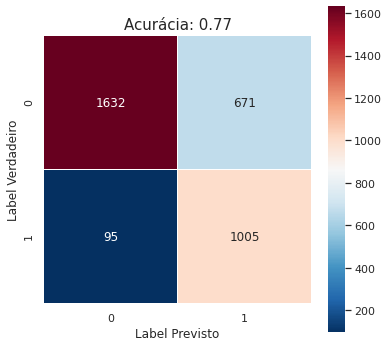

In [15]:
params = {'silent'       : 1,
          'objective'    : 'binary:logistic',
          'eval_metric'  : 'auc',
          'booster'      : 'gbtree',
          'lambda'       : 0.026834336727892413,
          'alpha'        : 0.0006039910566283139,
          'max_depth'    : 8,
          'eta'          : 0.0006565933008274129,
          'gamma'        : 0.0012661208934645076,
          'grow_policy' : 'depthwise'}


#modelo_xgb_v4 = xgb.XGBClassifier(**study_v2.best_params)
modelo_xgb_v4 = xgb.XGBClassifier(**params)

# Treinando o modelo
modelo_xgb_v4.fit(X_treino, y_treino)

# Fazendo previsões
xgb_y_pred = modelo_xgb_v4.predict(X_teste)
previsoes = [round(value) for value in xgb_y_pred]

# Avaliando as previsões
xgb_score_v4 = accuracy_score(y_teste, previsoes)
print("Acurácia: %.2f%%" % (xgb_score_v4 * 100.0))

# Cria a matriz de confusão
conf_matriz_xgb = confusion_matrix(y_teste, xgb_y_pred)
    
# Calcula especificidade e sensibilidade
speci_xgb = conf_matriz_xgb[0,0] / (conf_matriz_xgb[0,0] + conf_matriz_xgb[0,1])
sensi_xgb = conf_matriz_xgb[1,1] / (conf_matriz_xgb[1,0] + conf_matriz_xgb[1,1])

# Print
print('Sensibilidade :', sensi_xgb)
print('Especificidade :', speci_xgb)
print('\n')

# Matriz de Confusão gráfica
sns.set(rc={'figure.figsize':(6, 6)})
sns.heatmap(conf_matriz_xgb, 
            annot = True, 
            fmt = ".0f", 
            linewidths = .5, 
            square = True, 
            cmap = 'RdBu_r')

# Labels e Títulos
plt.ylabel('Label Verdadeiro')
plt.xlabel('Label Previsto')
plt.title('Acurácia: {:.2f}'.format(xgb_score_v4), size = 15)

# Relatório de Classificação
print(classification_report(y_teste, xgb_y_pred))

### Bayesian Optimization

In [16]:
#!pip install scikit-optimize --upgrade

In [17]:
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold


In [114]:
bayes_cv_tuner = BayesSearchCV(
    estimator = xgb.XGBClassifier(
        n_jobs      = -1,
        objective   = 'binary:logistic',
        eval_metric = 'auc',
        silent      = 1,
        tree_method = 'approx'
    ),
    search_spaces = {
        'learning_rate'    : (0.01, 1.0, 'log-uniform'),
        'min_child_weight' : (0, 10),
        'max_depth'        : (1, 10),
        'max_delta_step'   : (1, 20),
        'subsample'        : (0.01, 1.0, 'uniform'),
        'colsample_bytree' : (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda'       : (0, 1000, 'log-uniform'),
        'reg_alpha'        : (0, 1.0, 'log-uniform'),
        'gamma'            : (0, 0.5, 'log-uniform'),
        'min_child_weight' : (0, 5),
        'n_estimators'     : (100, 500),
        'scale_pos_weight' : (0, 500, 'log-uniform')
    },    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits     = 3,
        shuffle      = True,
        random_state = 42
    ),
    n_jobs  = -1,
    n_iter  = 20,   
    verbose = 0,
    refit   = True,
    random_state = 42
)

def status_print(optim_result):
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
    #all_models.to_csv(clf_name+"_cv_results.csv")

In [115]:
# Treinamento do modelo
result = bayes_cv_tuner.fit(X_treino, y_treino, callback=status_print)

Model #1
Best ROC-AUC: 0.8411
Best params: OrderedDict([('colsample_bylevel', 0.4160029192647807), ('colsample_bytree', 0.7304484857455519), ('gamma', 0), ('learning_rate', 0.042815319280763466), ('max_delta_step', 14), ('max_depth', 5), ('min_child_weight', 2), ('n_estimators', 396), ('reg_alpha', 0), ('reg_lambda', 648), ('scale_pos_weight', 275), ('subsample', 0.13556548021189216)])

Model #2
Best ROC-AUC: 0.8425
Best params: OrderedDict([('colsample_bylevel', 0.8390144719977516), ('colsample_bytree', 0.8844821246070537), ('gamma', 0), ('learning_rate', 0.7988179462781242), ('max_delta_step', 17), ('max_depth', 2), ('min_child_weight', 1), ('n_estimators', 241), ('reg_alpha', 1), ('reg_lambda', 953), ('scale_pos_weight', 315), ('subsample', 0.9923710598637134)])

Model #3
Best ROC-AUC: 0.8425
Best params: OrderedDict([('colsample_bylevel', 0.8390144719977516), ('colsample_bytree', 0.8844821246070537), ('gamma', 0), ('learning_rate', 0.7988179462781242), ('max_delta_step', 17), ('max

In [116]:
result.best_params_

OrderedDict([('colsample_bylevel', 0.2707699336992327),
             ('colsample_bytree', 0.7641868151379),
             ('gamma', 0),
             ('learning_rate', 0.19912880884108455),
             ('max_delta_step', 19),
             ('max_depth', 10),
             ('min_child_weight', 0),
             ('n_estimators', 396),
             ('reg_alpha', 0),
             ('reg_lambda', 540),
             ('scale_pos_weight', 29),
             ('subsample', 0.6898551324163398)])

Acurácia: 78.46%
Sensibilidade : 1.0
Especificidade : 0.681719496309162


              precision    recall  f1-score   support

           0       1.00      0.68      0.81      2303
           1       0.60      1.00      0.75      1100

    accuracy                           0.78      3403
   macro avg       0.80      0.84      0.78      3403
weighted avg       0.87      0.78      0.79      3403



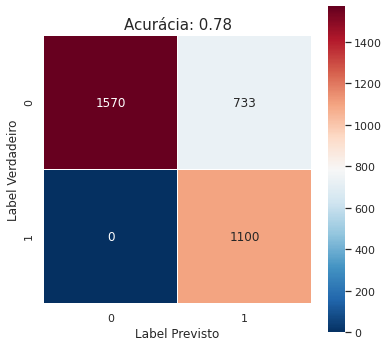

In [117]:
modelo_xgb_v5 = xgb.XGBClassifier(**result.best_params_)

# Treinando o modelo
modelo_xgb_v5.fit(X_treino, y_treino)

# Fazendo previsões
xgb_y_pred = modelo_xgb_v5.predict(X_teste)
previsoes = [round(value) for value in xgb_y_pred]

# Avaliando as previsões
xgb_score_v5 = accuracy_score(y_teste, previsoes)
print("Acurácia: %.2f%%" % (xgb_score_v5 * 100.0))

# Cria a matriz de confusão
conf_matriz_xgb = confusion_matrix(y_teste, xgb_y_pred)
    
# Calcula especificidade e sensibilidade
speci_xgb = conf_matriz_xgb[0,0] / (conf_matriz_xgb[0,0] + conf_matriz_xgb[0,1])
sensi_xgb = conf_matriz_xgb[1,1] / (conf_matriz_xgb[1,0] + conf_matriz_xgb[1,1])

# Print
print('Sensibilidade :', sensi_xgb)
print('Especificidade :', speci_xgb)
print('\n')

# Matriz de Confusão gráfica
sns.set(rc={'figure.figsize':(6, 6)})
sns.heatmap(conf_matriz_xgb, 
            annot = True, 
            fmt = ".0f", 
            linewidths = .5, 
            square = True, 
            cmap = 'RdBu_r')

# Labels e Títulos
plt.ylabel('Label Verdadeiro')
plt.xlabel('Label Previsto')
plt.title('Acurácia: {:.2f}'.format(xgb_score_v5), size = 15)

# Relatório de Classificação
print(classification_report(y_teste, xgb_y_pred))

# Parte 05. Realizando novas previsões

In [118]:
# Carregando o dataset de testes 
teste  = pd.read_csv(r'to_be_scored.csv')
print('Quantidade de registros e colunas: ',teste.shape)

# Removendo colunas que não serão utilizadas no treinamento
teste = teste.drop(['Tempo','Estação','Movimentação','LAT','LONG'], axis = 1)

# Visualizando os primeiros registros
teste.head()

Quantidade de registros e colunas:  (984, 13)


,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego
0,22,65,22,14,3,26,43,18
1,11,56,16,14,43,20,37,15
2,86,51,8,11,41,20,35,12
3,76,47,65,11,37,14,32,10
4,68,42,60,6,35,13,26,5


In [119]:
# Padronizando os dados (0 para a média, 1 para o desvio padrão)
teste_scaler = StandardScaler().fit_transform(teste)

# Realizando previsoes com dados de teste(usando modelo NAO BALANCEADO)
y_pred_test = modelo_xgb_v5.predict(teste_scaler)


In [120]:
# Salvando na coluna target
teste['TARGET'] = y_pred_test
teste['TARGET'] = np.where(teste['TARGET'] == 0, 'NORMAL', 'REABASTECER')

# Visualizando os ultimos registros
teste.tail()

,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,TARGET
979,34,65,28,17,33,27,6,2,REABASTECER
980,21,60,18,15,27,22,43,43,NORMAL
981,9,56,13,14,21,17,37,37,REABASTECER
982,86,49,7,14,17,12,33,33,REABASTECER
983,74,41,65,8,14,7,27,27,NORMAL


,TARGET,%
REABASTECER,532,54.065
NORMAL,452,45.935


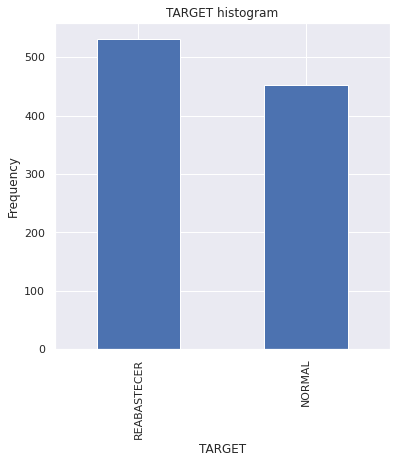

In [121]:
# Visualizando a distribuição das classes (variavel TARGET)
pd.value_counts(teste['TARGET']).plot.bar()
plt.title('TARGET histogram')
plt.xlabel('TARGET')
plt.ylabel('Frequency')

# Visualizando um df com quantidade e percentual da variavel TARGET
tmp = pd.DataFrame(teste['TARGET'].value_counts())
tmp['%'] = round(100*tmp['TARGET']/tmp['TARGET'].sum(),3)
tmp

In [122]:
# Gravando resultado em csv
teste.to_csv('results_xgb_v2.csv',index=False)